<a href="https://colab.research.google.com/github/erbisti/Collab/blob/main/VAE%20completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - kl_loss: 2.2140 - loss: 212.0883 - reconstruction_loss: 209.8742 - val_loss: 0.0594
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 2.8385 - loss: 179.4034 - reconstruction_loss: 176.5649 - val_loss: 0.0508
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.5773 - loss: 164.1001 - reconstruction_loss: 160.5228 - val_loss: 0.0472
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.7220 - loss: 159.0246 - reconstruction_loss: 155.3026 - val_loss: 0.0456
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.7792 - loss: 156.5659 - reconstruction_loss: 152.7867 - val_loss: 0.0444
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 3.8052 - loss: 154.8683 - reconstruction_loss: 151.0631 - val_loss: 0.0439
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 3.8190 - loss: 153.8056 - reconstruction_loss: 149.9866 - val_loss: 0.0436
Epoch 8/15
469/469 ━━━━━━━━━━━━━

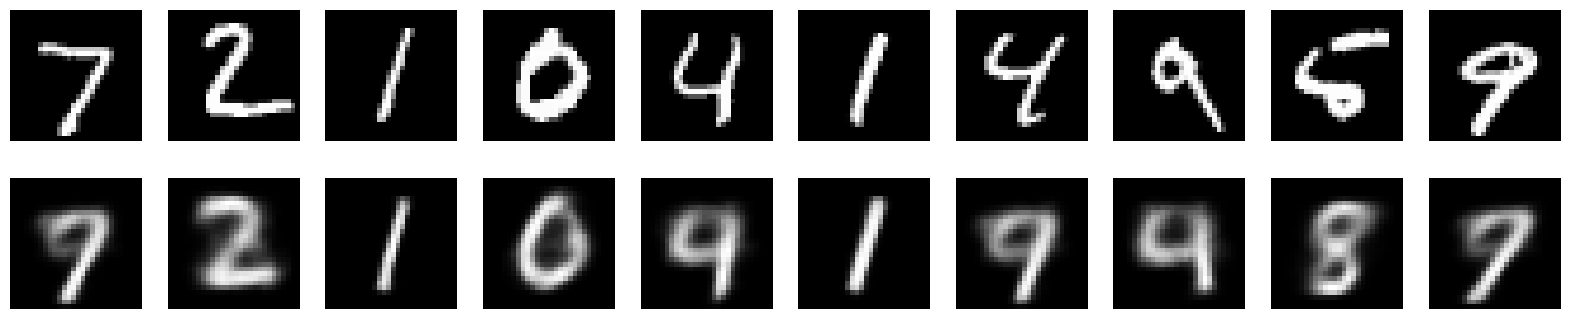

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# ===== 1. Carregamento e preparação dos dados =====
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# ===== 2. Parâmetros =====
latent_dim = 2

# ===== 3. Encoder =====
encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# ===== 4. Decoder =====
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# ===== 5. Modelo VAE com cálculo manual da perda =====
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * 28 * 28

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# ===== 6. Instanciamento e treinamento =====
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())  # Dummy loss
vae.fit(x_train, x_train,
        epochs=15,
        batch_size=128,
        validation_data=(x_test, x_test))

# ===== 7. Visualização das reconstruções =====
decoded_imgs = vae.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


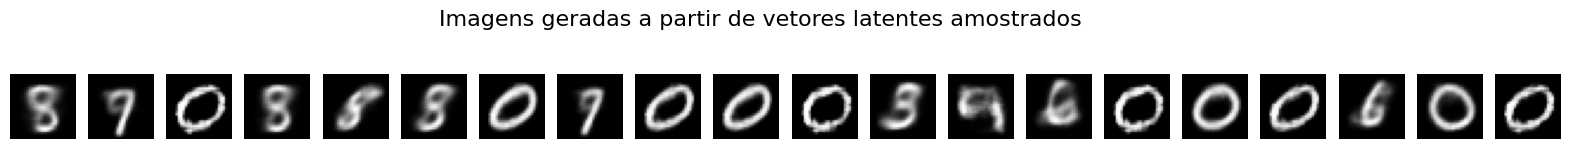

In [9]:
# ===== 8. Geração de imagens novas (sem entrada) =====
# Amostragem aleatória no espaço latente aprendido
n = 20  # número de imagens a gerar
latent_samples = np.random.normal(size=(n, latent_dim))  # z ~ N(0, I)

# Geração com o decodificador treinado
generated_imgs = decoder.predict(latent_samples)

# Visualização
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("Imagens geradas a partir de vetores latentes amostrados", fontsize=16)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

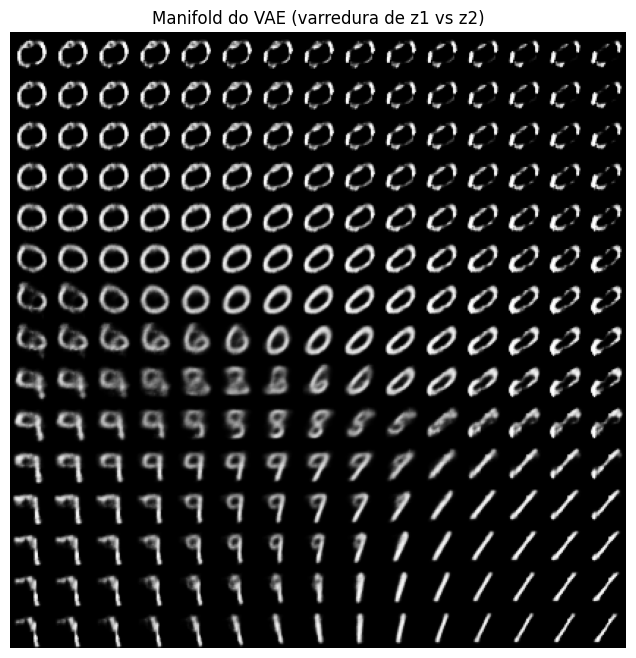

In [4]:
# ===== 9. Varredura em grade do espaço latente (somente latent_dim = 2) =====
# Gera uma grade de pontos em z1 x z2 e decodifica cada ponto para ver a manifold
grid_n = 15
z_lin = np.linspace(-3.0, 3.0, grid_n)  # quantis aproximados da N(0,1)
canvas = np.zeros((28*grid_n, 28*grid_n))

row = 0
for i, zi in enumerate(z_lin):
    col = 0
    for j, zj in enumerate(z_lin):
        z_ij = np.array([[zi, zj]], dtype=np.float32)
        x_ij = decoder.predict(z_ij)[0].squeeze()
        canvas[row:row+28, col:col+28] = x_ij
        col += 28
    row += 28

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title("Manifold do VAE (varredura de z1 vs z2)")
plt.show()


# Interpolação no espaço latente - morfagem de dígitos


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


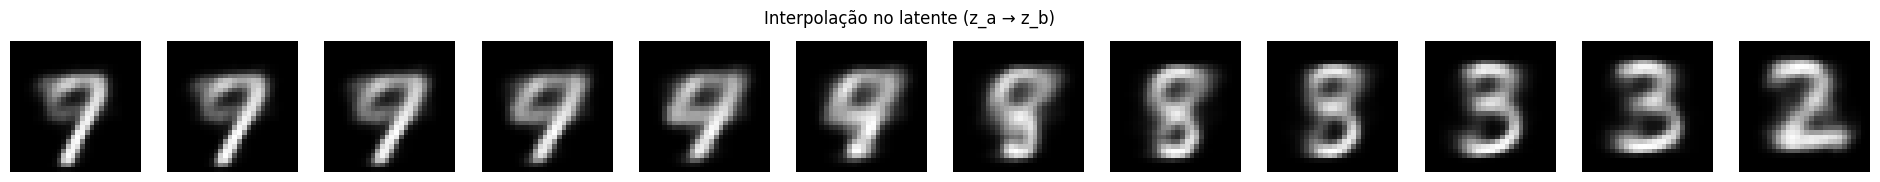

In [10]:
# ===== 10. Interpolação no latente entre duas imagens do conjunto =====
# pega duas imagens do x_test, codifica -> (z_mean_a, z_mean_b), interpola e decodifica
idx_a, idx_b = 0, 1  # pode trocar
z_mean_a, z_log_var_a, _ = encoder.predict(x_test[idx_a:idx_a+1])
z_mean_b, z_log_var_b, _ = encoder.predict(x_test[idx_b:idx_b+1])

steps = 12
alphas = np.linspace(0, 1, steps)
interp_imgs = []

for a in alphas:
    z_interp = (1 - a) * z_mean_a + a * z_mean_b
    x_hat = decoder.predict(z_interp)[0].squeeze()
    interp_imgs.append(x_hat)

plt.figure(figsize=(2*steps, 2))
for i, img in enumerate(interp_imgs):
    ax = plt.subplot(1, steps, i + 1)
    plt.imshow(img, cmap='gray')
    ax.axis('off')
plt.suptitle("Interpolação no latente (z_a → z_b)")
plt.show()
